# Tests of resampling techniques for imbalanced datasets

In [1]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTENC, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import ClusterCentroids, TomekLinks, RandomUnderSampler
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import matplotlib
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
def scatterer (df):
    plt.figure(figsize=(6,6))
    plt.scatter(df.query('gentau_decayMode==0')['cl3d_hoe'], df.query('gentau_decayMode==0')['cl3d_meanz'], alpha=0.1, label='PU')
    plt.scatter(df.query('gentau_decayMode==1')['cl3d_hoe'], df.query('gentau_decayMode==1')['cl3d_meanz'], alpha=0.1, label='tau')
    plt.legend()
    plt.xlim(0,12)
    plt.xlabel('hoe')
    plt.ylabel('meanz')
    plt.ylim(310,525)
    plt.show()
    
def plotter (dfTr, df=pd.DataFrame()):
    fig = plt.figure(figsize = (13,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.hist(dfTr.query('gentau_decayMode==1')['cl3d_hoe'], bins=np.arange(0,5,0.05), histtype='step', density=True, alpha=0.5, label='tau from gen')
    if not df.empty: 
        old_index = dfTr.set_index('cl3d_hoe').index
        new_index = df.set_index('cl3d_hoe').index
        mask = ~new_index.isin(old_index)
        df = df.loc[mask]
        ax1.hist(df.query('gentau_decayMode==1')['cl3d_hoe'], bins=np.arange(0,5,0.05), histtype='step', density=True, alpha=0.5, label='tau from resampling')
    ax1.legend()
    ax1.set_xlabel('hoe')
    ax1.set_ylabel('a.u.')
    
    ax2.hist(dfTr.query('gentau_decayMode==1')['cl3d_meanz'], bins=np.arange(325,425,2), histtype='step', density=True, alpha=0.5, label='tau from gen')
    if not df.empty: 
        ax2.hist(df.query('gentau_decayMode==1')['cl3d_meanz'], bins=np.arange(325,425,2), histtype='step', density=True, alpha=0.5, label='tau from resampling')
    ax2.legend()
    ax2.set_xlabel('meanz')
    ax2.set_ylabel('a.u.')

    fig.show

In [3]:
# create needed folders
indir = '/home/llr/cms/motta/HGCAL/CMSSW_11_1_0/src/GRAPHAnalysis/L1BDT/hdf5dataframes/matched'

name = 'threshold'
    
# define the input and output dictionaries for the handling of different datasets
inFileTraining_dict = {
    'threshold'    : indir+'/Training_PU200_th_matched.hdf5',
    'mixed'        : indir+'/'
}

dfTraining_dict = {}

In [4]:
store_tr = pd.HDFStore(inFileTraining_dict[name], mode='r')
dfTraining_dict[name] = store_tr[name]
store_tr.close()
dfTraining_dict[name]['cl3d_abseta'] = np.abs(dfTraining_dict[name]['cl3d_eta'])
        
# here we apply minimal requirements so that we are working in a fiducial region slightly smaller than the full HGCAL acceptance
# we apply the OR between tau, jet, and cluster requirements
dfTraining_dict[name].query('(cl3d_pt>4 and cl3d_abseta>1.6 and cl3d_abseta<2.9) or ((gentau_vis_pt>20 and ((gentau_vis_eta>1.6 and gentau_vis_eta<2.9) or (gentau_vis_eta<-1.6 and gentau_vis_eta>-2.9))) or (genjet_pt>20 and ((genjet_eta>1.6 and genjet_eta<2.9) or (genjet_eta<-1.6 and genjet_eta>-2.9))))', inplace=True)

# for the actual training and validation we enforce the AND between tau and cluster requirements
dfTr = dfTraining_dict[name].copy(deep=True)

del dfTraining_dict

In [5]:
dfTr.query('(geom_match==False and (gentau_decayMode==-99.9 or gentau_decayMode==-1 or gentau_decayMode==-2)) or (gentau_decayMode>=0 and cl3d_isbestmatch==True)', inplace=True)
dfTr.replace([0,1,10,11], 1, inplace=True)
dfTr.replace([-1, -99.9, -2], 0, inplace=True)

# only keep the needed stuff
keep = ['cl3d_abseta', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'gentau_decayMode']
dfTr = dfTr[keep]

print('tot', dfTr.shape[0])
print('tau', dfTr.query('gentau_decayMode==1').shape[0])
print('pu', dfTr.query('gentau_decayMode==0').shape[0])

tot 4655776
tau 19542
pu 4636234


In [6]:
features = ['cl3d_abseta', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90']
output = 'gentau_decayMode'

X_train, X_test, Y_train, Y_test = train_test_split(dfTr[features], dfTr[output], stratify=dfTr[output], test_size=0.3)

print('tot', Y_train.shape[0])
print('tau', Y_train[Y_train==1].shape[0])
print('pu', Y_train[Y_train==0].shape[0])

tot 3259043
tau 13679
pu 3245364


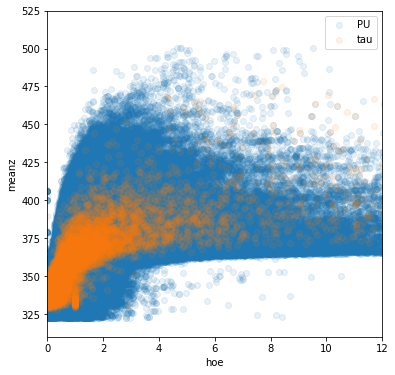

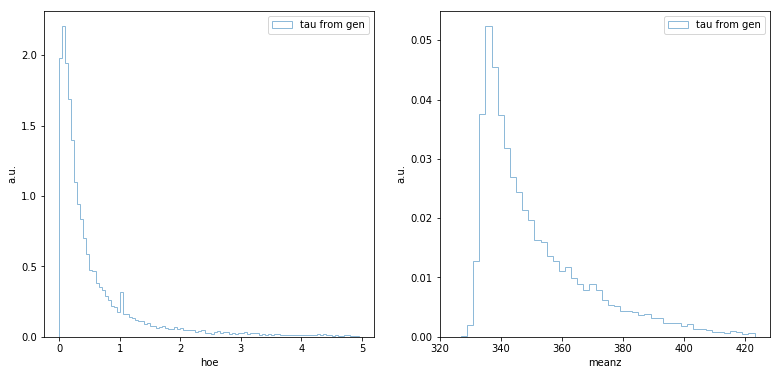

In [7]:
scatterer(dfTr)
plotter(dfTr)

### OVERSAMPLING

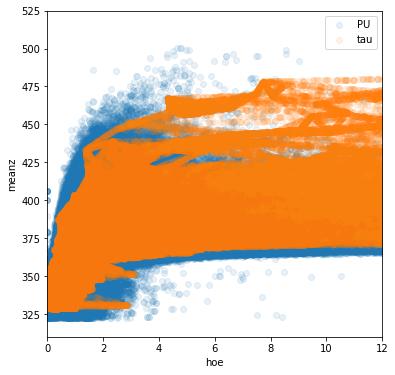

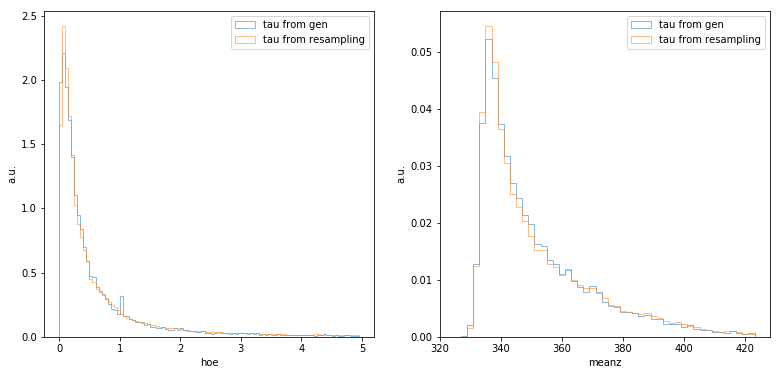

In [8]:
X_smote, Y_smote = SMOTE(sampling_strategy=1.0).fit_resample(X_train, Y_train)

y = pd.DataFrame(Y_smote)
df = pd.concat([X_smote,y], axis=1, sort=False)

scatterer(df)
plotter(dfTr, df)

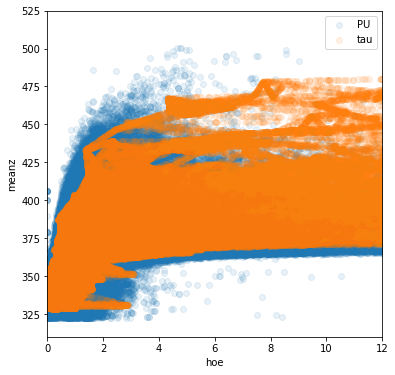

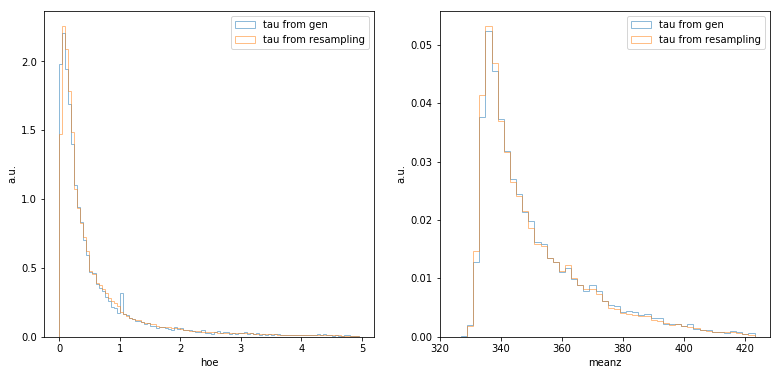

In [9]:
X_adasyn, Y_adasyn = ADASYN(sampling_strategy=1.0).fit_resample(X_train, Y_train)

y = pd.DataFrame(Y_adasyn)
df = pd.concat([X_adasyn,y], axis=1, sort=False)

scatterer(df)
plotter(dfTr, df)

### UNDERSAMPLING

In [10]:
#X_clustcentr, Y_clustcentr = ClusterCentroids(sampling_strategy=0.5).fit_resample(X_train, Y_train)
#
#y = pd.DataFrame(Y_clustcentr)
#df = pd.concat([X_clustcentr,y], axis=1, sort=False)
#
#plt.figure(figsize=(8,8))
#plt.scatter(df.query('gentau_decayMode==0')['cl3d_hoe'], df.query('gentau_decayMode==0')['cl3d_meanz'], alpha=0.5, label='PU')
#plt.scatter(df.query('gentau_decayMode==1')['cl3d_hoe'], df.query('gentau_decayMode==1')['cl3d_meanz'], alpha=0.5, label='tau')
#plt.legend()
#plt.xlim(0,12)
#plt.xlabel('hoe')
#plt.ylabel('meanz')
#plt.show()

In [11]:
#print('before TomeLinks')
#print('tot', Y.shape[0])
#print('tau', Y[Y==1].shape[0])
#print('pu', Y[Y==0].shape[0])
#
#X_tomek, Y_tomek = TomeLinks().fit_resample(X_resampled, Y_resampled)
#
#print('after TomeLinks')
#print('tot', Y.shape[0])
#print('tau', Y[Y==1].shape[0])
#print('pu', Y[Y==0].shape[0])
#
#y = pd.DataFrame(Y_tomek)
#df = pd.concat([X_tomek,y], axis=1, sort=False)
#
#plotter(df)

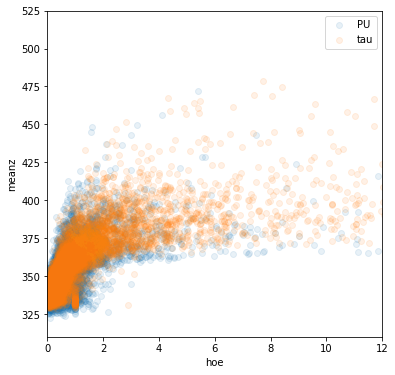

In [12]:
X_rndsmp, Y_rndsmp = RandomUnderSampler(sampling_strategy=1.0).fit_resample(X_train, Y_train)

y = pd.DataFrame(Y_rndsmp)
df = pd.concat([X_rndsmp,y], axis=1, sort=False)

scatterer(df)

### MIXED UNDER-OVER

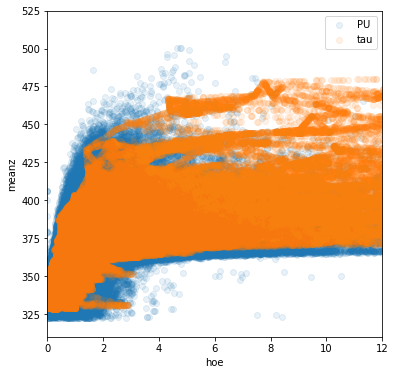

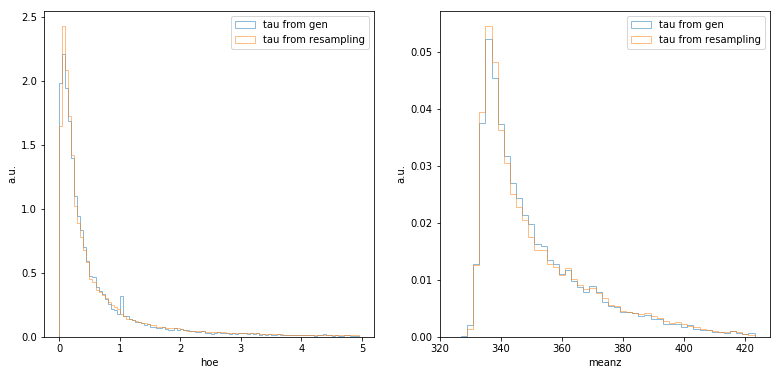

In [13]:
X_mix1, Y_mix1 = SMOTE(sampling_strategy=0.5).fit_resample(X_train, Y_train)
X_mix1, Y_mix1 = RandomUnderSampler(sampling_strategy=1.0).fit_resample(X_mix1, Y_mix1)

y = pd.DataFrame(Y_mix1)
df = pd.concat([X_mix1,y], axis=1, sort=False)

scatterer(df)
plotter(dfTr, df)

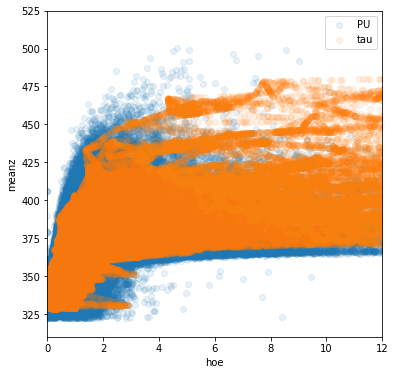

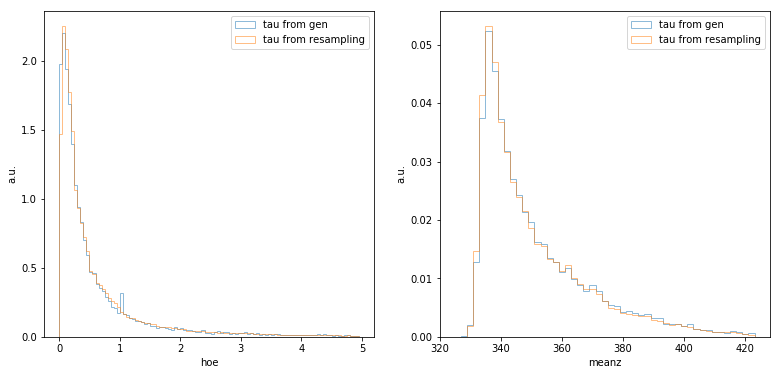

In [14]:
X_mix2, Y_mix2 = ADASYN(sampling_strategy=0.5).fit_resample(X_train, Y_train)
X_mix2, Y_mix2 = RandomUnderSampler(sampling_strategy=1.0).fit_resample(X_mix2, Y_mix2)

y = pd.DataFrame(Y_mix2)
df = pd.concat([X_mix2,y], axis=1, sort=False)

scatterer(df)
plotter(dfTr, df)

## BDT TRAINING

In [15]:
def train_xgb(X_train, X_test, Y_train, Y_test, features, output, hyperparams, evals_dict={}):
    train = xgb.DMatrix(data=X_train,label=Y_train, feature_names=features)
    test = xgb.DMatrix(data=X_test,label=Y_test,feature_names=features)
    booster = xgb.train(hyperparams, train, num_boost_round=200, evals=[(test,'test'), (train,'train')], verbose_eval=0, evals_result=evals_dict)
    train_output = booster.predict(train)
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(Y_train, train_output)
    test_output = booster.predict(test)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(Y_test, test_output)

    auroc_test = metrics.roc_auc_score(Y_test,test_output)
    auroc_train = metrics.roc_auc_score(Y_train,train_output)
    
    return fpr_train, tpr_train, fpr_test, tpr_test, auroc_test, auroc_train, evals_dict
    
def cv_xgb(X_train, X_test, Y_train, Y_test, features, output, hyperparams):
    train = xgb.DMatrix(data=X_train,label=Y_train, feature_names=features)
    test = xgb.DMatrix(data=X_test,label=Y_test,feature_names=features)
    cv_results = xgb.cv(hyperparams, train, num_boost_round=200, nfold=5, metrics={'logloss', 'auc', 'error@0.012', 'error@0.003', 'error@0.0007', 'aucpr'}, verbose_eval=0)

    return cv_results


params = {'eval_metric'      : 'logloss',
          'objective'        : 'binary:logistic', # objective function
          'nthread'          : 10, # limit number of threads
          'eta'              : 0.14, # learning rate
          'max_depth'        : 3, # maximum depth of a tree
          'subsample'        : 0.8, # fraction of events to train tree on
          'colsample_bytree' : 0.3 # fraction of features to train tree on
}

In [16]:
FPRs_train = {}
TPRs_train = {}
AUCs_train = {}
FPRs_test = {}
TPRs_test = {}
AUCs_test = {}
EVALs_train = {}
CVs_results = {}

In [17]:
#X_train = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_train), columns=features)
#X_smote = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_smote), columns=features)
#X_adasyn = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_adasyn), columns=features)
#X_rndsmp = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_rndsmp), columns=features)
#X_mix1 = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_mix1), columns=features)
#X_mix2 = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_mix2), columns=features)

In [18]:
CVs_results['untouched'] = cv_xgb(X_train, X_test, Y_train, Y_test, features, output, params)
CVs_results['SMOTE'] = cv_xgb(X_smote, X_test, Y_smote, Y_test, features, output, params)
CVs_results['ADASYN'] = cv_xgb(X_adasyn, X_test, Y_adasyn, Y_test, features, output, params)
CVs_results['RandomUnderSampler'] = cv_xgb(X_rndsmp, X_test, Y_rndsmp, Y_test, features, output, params)
CVs_results['Mix1'] = cv_xgb(X_mix1, X_test, Y_mix1, Y_test, features, output, params)
CVs_results['Mix2'] = cv_xgb(X_mix2, X_test, Y_mix2, Y_test, features, output, params)

In [19]:
fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_train, X_test, Y_train, Y_test, features, output, params)
FPRs_train['untouched'] = fpr_train
TPRs_train['untouched'] = tpr_train
AUCs_train['untouched'] = round(trainAuroc,3)
FPRs_test['untouched'] = fpr_test
TPRs_test['untouched'] = tpr_test
AUCs_test['untouched'] = round(testAuroc,3)
EVALs_train['untouched'] = evals

fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_smote, X_test, Y_smote, Y_test, features, output, params)
FPRs_train['SMOTE'] = fpr_train
TPRs_train['SMOTE'] = tpr_train
AUCs_train['SMOTE'] = round(trainAuroc,3)
FPRs_test['SMOTE'] = fpr_test
TPRs_test['SMOTE'] = tpr_test
AUCs_test['SMOTE'] = round(testAuroc,3)
EVALs_train['SMOTE'] = evals

fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_adasyn, X_test, Y_adasyn, Y_test, features, output, params)
FPRs_train['ADASYN'] = fpr_train
TPRs_train['ADASYN'] = tpr_train
AUCs_train['ADASYN'] = round(trainAuroc,3)
FPRs_test['ADASYN'] = fpr_test
TPRs_test['ADASYN'] = tpr_test
AUCs_test['ADASYN'] = round(testAuroc,3)
EVALs_train['ADASYN'] = evals


#fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc = train_xgb(X_clustcentr, X_test, Y_clustcentr, Y_test, features, output, params)
#FPRs_train.append(fpr_train)
#TPRs_train.append(tpr_train)
#AUCs_train.append(testAuroc)
#FPRs_test.append(fpr_test)
#TPRs_test.append(tpr_test)
#AUCs_test.append(trainAuroc)

#fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc = train_xgb(X_tomek, X_test, Y_tomek, Y_test, features, output, params)
#FPRs_train.append(fpr_train)
#TPRs_train.append(tpr_train)
#AUCs_train.append(testAuroc)
#FPRs_test.append(fpr_test)
#TPRs_test.append(tpr_test)
#AUCs_test.append(trainAuroc)

fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_rndsmp, X_test, Y_rndsmp, Y_test, features, output, params)
FPRs_train['RandomUnderSampler'] = fpr_train
TPRs_train['RandomUnderSampler'] = tpr_train
AUCs_train['RandomUnderSampler'] = round(trainAuroc,3)
FPRs_test['RandomUnderSampler'] = fpr_test
TPRs_test['RandomUnderSampler'] = tpr_test
AUCs_test['RandomUnderSampler'] = round(testAuroc,3)
EVALs_train['RandomUnderSampler'] = evals

fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_mix1, X_test, Y_mix1, Y_test, features, output, params)
FPRs_train['Mix1'] = fpr_train
TPRs_train['Mix1'] = tpr_train
AUCs_train['Mix1'] = round(trainAuroc,3)
FPRs_test['Mix1'] = fpr_test
TPRs_test['Mix1'] = tpr_test
AUCs_test['Mix1'] = round(testAuroc,3)
EVALs_train['Mix1'] = evals

fpr_train, tpr_train, fpr_test, tpr_test, testAuroc, trainAuroc, evals = train_xgb(X_mix2, X_test, Y_mix2, Y_test, features, output, params)
FPRs_train['Mix2'] = fpr_train
TPRs_train['Mix2'] = tpr_train
AUCs_train['Mix2'] = round(trainAuroc,3)
FPRs_test['Mix2'] = fpr_test
TPRs_test['Mix2'] = tpr_test
AUCs_test['Mix2'] = round(testAuroc,3)
EVALs_train['Mix2'] = evals

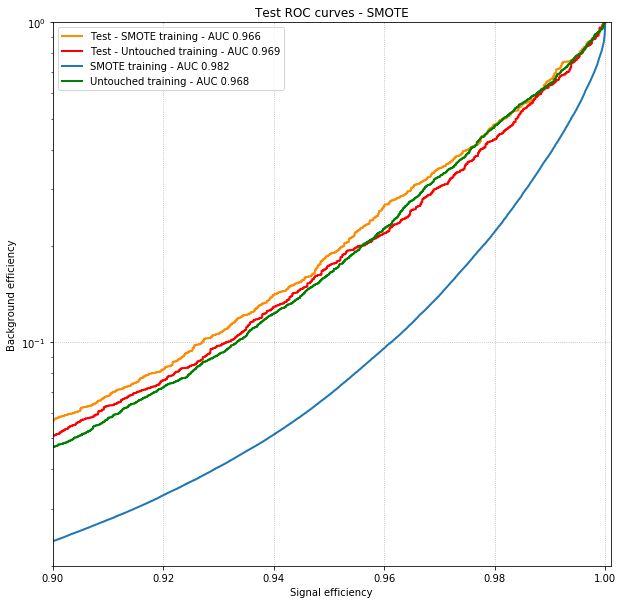

In [42]:
strategy = 'SMOTE'

plt.figure(figsize=(10,10))
plt.plot(TPRs_test[strategy],FPRs_test[strategy],label='Test - '+strategy+' training - AUC '+str(AUCs_test[strategy]),lw=2, color='darkorange')
plt.plot(TPRs_test['untouched'],FPRs_test['untouched'],label='Test - Untouched training - AUC '+str(AUCs_test['untouched']),lw=2, color='red')
plt.plot(TPRs_train[strategy],FPRs_train[strategy],label=strategy+' training - AUC '+str(AUCs_train[strategy]),lw=2, color='tab:blue')
plt.plot(TPRs_train['untouched'],FPRs_train['untouched'],label='Untouched training - AUC '+str(AUCs_train['untouched']),lw=2, color='green')   
plt.grid(linestyle=':')
plt.legend(loc = 'upper left')
plt.xlim(0.90,1.001)
plt.yscale('log')
plt.ylim(0.02,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency') 
plt.title('Test ROC curves - '+strategy)
plt.show()

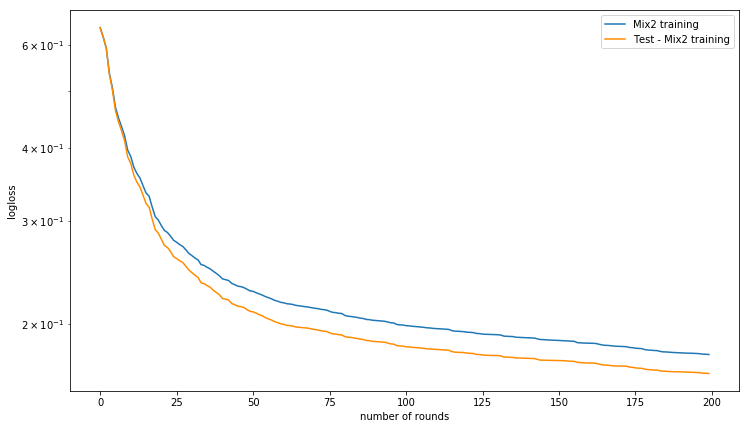

In [65]:
strategy = 'Mix2'

plt.figure(figsize=(12,7))
x_axis=range(0,len(EVALs_train[strategy]['test']['logloss']))
plt.errorbar(x=x_axis,y=EVALs_train[strategy]['train']['logloss'],xerr=None, yerr=None, label=strategy+' training', color='tab:blue')
plt.errorbar(x=x_axis,y=EVALs_train[strategy]['test']['logloss'],xerr=None, yerr=None, label='Test - '+strategy+' training', color='darkorange')
#plt.errorbar(x=x_axis,y=evals_train['untouched']['train']['logloss'],xerr=None, yerr=None, label='Train untouched', color='red')
#plt.errorbar(x=x_axis,y=evals_train['untouched']['test']['logloss'],xerr=None, yerr=None, label='Test untouched', color='green')
plt.ylabel('logloss')
plt.yscale('log')
plt.xlabel('number of rounds')
plt.legend()
plt.show()

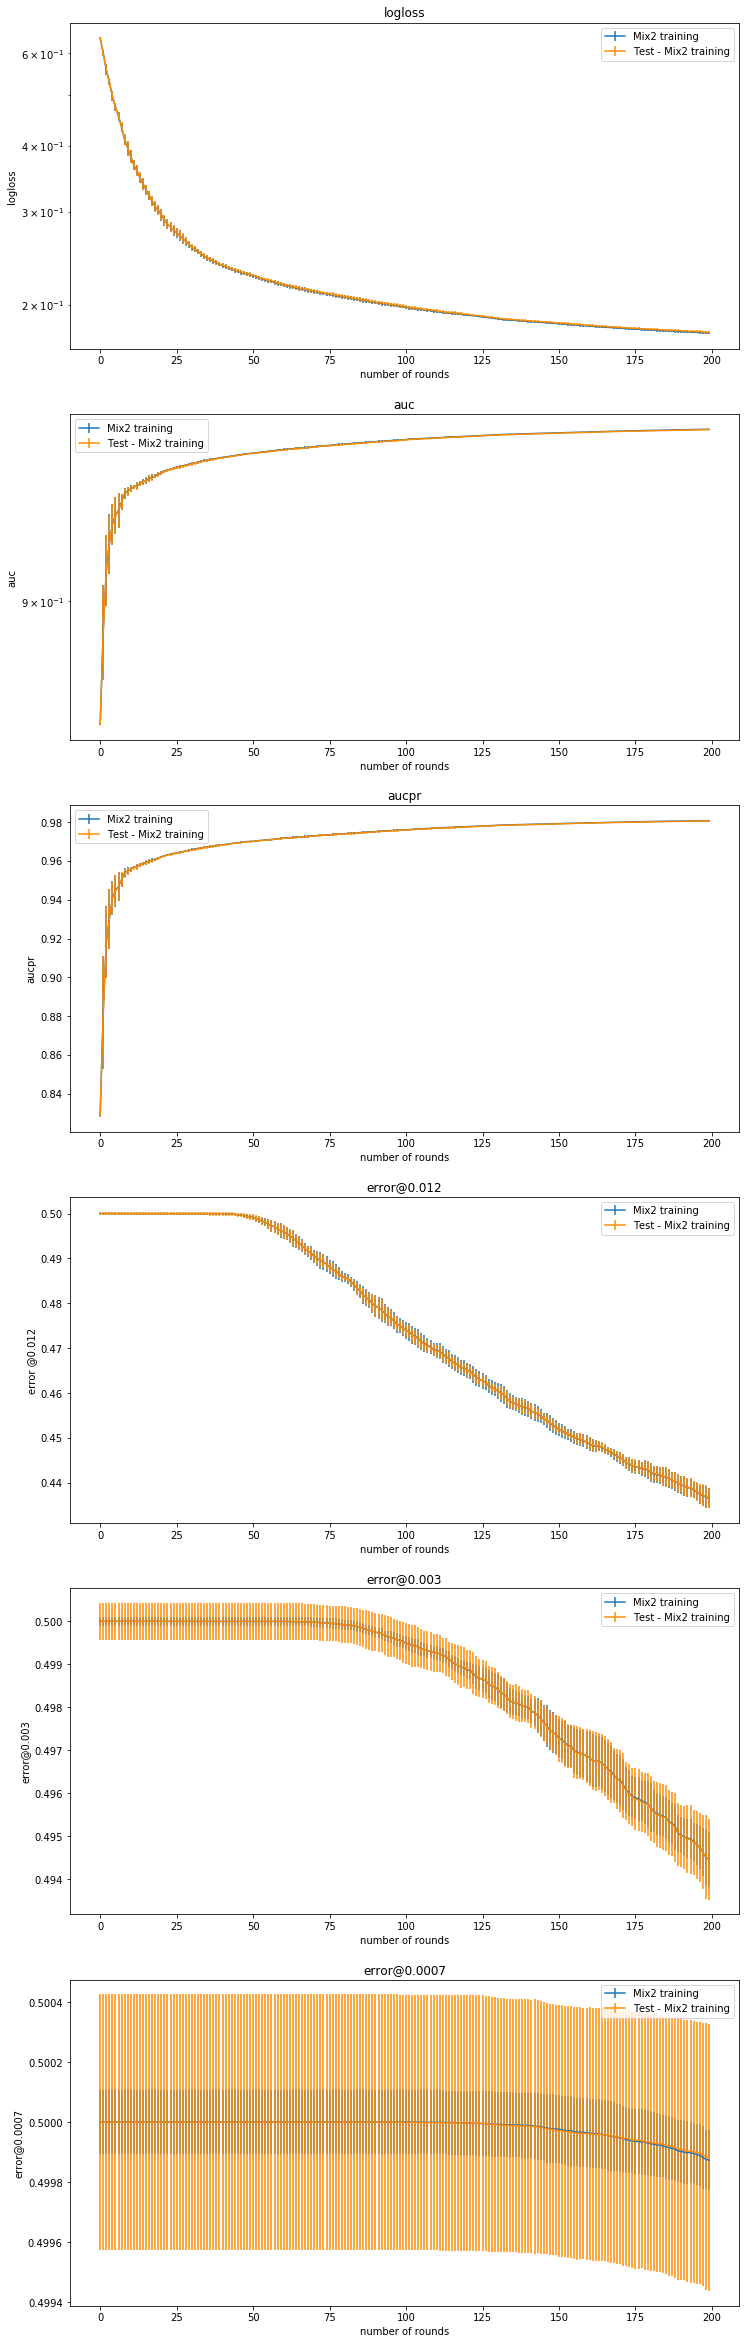

In [60]:
strategy = 'Mix2'

fig = plt.figure(figsize = (12,42))
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)
x_axis=range(0,len(CVs_results['untouched']['test-logloss-mean']))

ax1.errorbar(x=x_axis,y=CVs_results[strategy]['train-logloss-mean'],xerr=None, yerr=CVs_results[strategy]['train-logloss-std'], label=strategy+' training', color='tab:blue')
ax1.errorbar(x=x_axis,y=CVs_results[strategy]['test-logloss-mean'],xerr=None, yerr=CVs_results[strategy]['test-logloss-std'], label='Test - '+strategy+' training', color='darkorange')
ax1.set_xlabel('number of rounds')
ax1.set_ylabel('logloss')
ax1.set_title('logloss')
ax1.set_yscale('log')
ax1.legend()

ax2.errorbar(x=x_axis,y=CVs_results[strategy]['train-auc-mean'],xerr=None, yerr=CVs_results[strategy]['train-auc-std'], label=strategy+' training', color='tab:blue')
ax2.errorbar(x=x_axis,y=CVs_results[strategy]['test-auc-mean'],xerr=None, yerr=CVs_results[strategy]['test-auc-std'], label='Test - '+strategy+' training', color='darkorange')
ax2.set_xlabel('number of rounds')
ax2.set_ylabel('auc')
ax2.set_title('auc')
ax2.set_yscale('log')
ax2.legend()

ax3.errorbar(x=x_axis,y=CVs_results[strategy]['train-aucpr-mean'],xerr=None, yerr=CVs_results[strategy]['train-aucpr-std'], label=strategy+' training', color='tab:blue')
ax3.errorbar(x=x_axis,y=CVs_results[strategy]['test-aucpr-mean'],xerr=None, yerr=CVs_results[strategy]['test-aucpr-std'], label='Test - '+strategy+' training', color='darkorange')
ax3.set_xlabel('number of rounds')
ax3.set_ylabel('aucpr')
ax3.set_title('aucpr')
ax3.legend()

ax4.errorbar(x=x_axis,y=CVs_results[strategy]['train-error@0.012-mean'],xerr=None, yerr=CVs_results[strategy]['train-error@0.012-std'], label=strategy+' training', color='tab:blue')
ax4.errorbar(x=x_axis,y=CVs_results[strategy]['test-error@0.012-mean'],xerr=None, yerr=CVs_results[strategy]['test-error@0.012-std'], label='Test - '+strategy+' training', color='darkorange')
ax4.set_xlabel('number of rounds')
ax4.set_ylabel('error @0.012')
ax4.set_title('error@0.012')
ax4.legend()

ax5.errorbar(x=x_axis,y=CVs_results[strategy]['train-error@0.003-mean'],xerr=None, yerr=CVs_results[strategy]['train-error@0.003-std'], label=strategy+' training', color='tab:blue')
ax5.errorbar(x=x_axis,y=CVs_results[strategy]['test-error@0.003-mean'],xerr=None, yerr=CVs_results[strategy]['test-error@0.003-std'], label='Test - '+strategy+' training', color='darkorange')
ax5.set_xlabel('number of rounds')
ax5.set_ylabel('error@0.003')
ax5.set_title('error@0.003')
ax5.legend()

ax6.errorbar(x=x_axis,y=CVs_results[strategy]['train-error@0.0007-mean'],xerr=None, yerr=CVs_results[strategy]['train-error@0.0007-std'], label=strategy+' training', color='tab:blue')
ax6.errorbar(x=x_axis,y=CVs_results[strategy]['test-error@0.0007-mean'],xerr=None, yerr=CVs_results[strategy]['test-error@0.0007-std'], label='Test - '+strategy+' training', color='darkorange')
ax6.set_xlabel('number of rounds')
ax6.set_ylabel('error@0.0007')
ax6.set_title('error@0.0007')
ax6.legend()

fig.show()

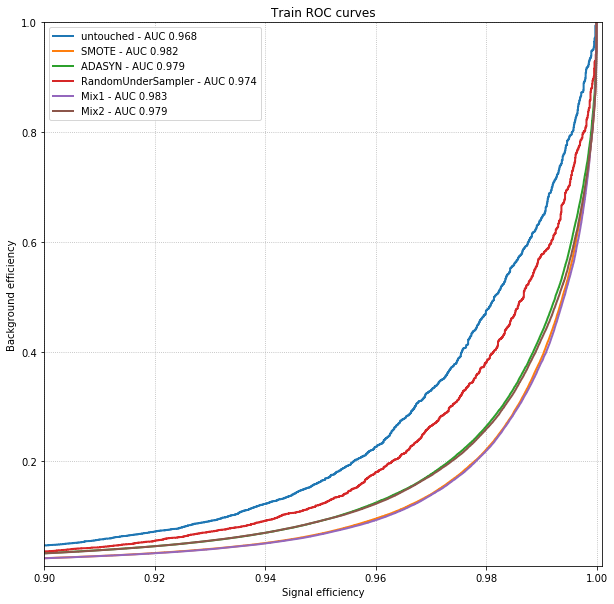

In [66]:
plt.figure(figsize=(10,10))
for strategy in TPRs_train:
    plt.plot(TPRs_train[strategy],FPRs_train[strategy],label=strategy+' - AUC '+str(AUCs_train[strategy]),lw=2)
plt.grid(linestyle=':')
plt.legend(loc = 'upper left')
plt.xlim(0.9,1.001)
#plt.yscale('log')
plt.ylim(0.01,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency') 
plt.title('Train ROC curves')
plt.show()

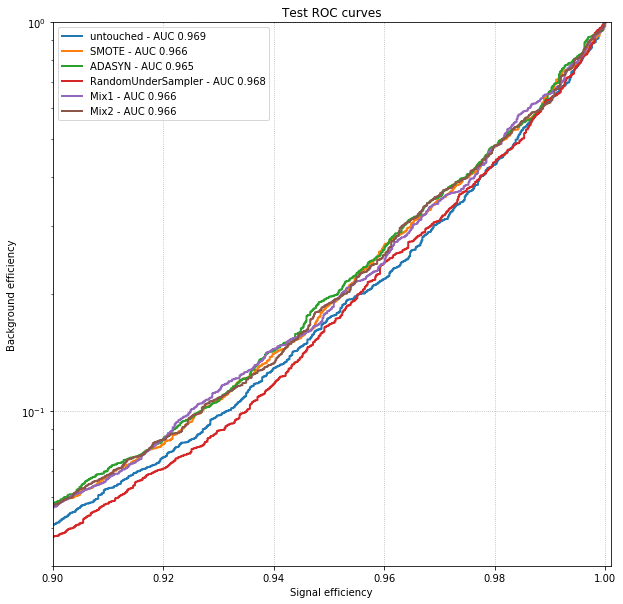

In [67]:
plt.figure(figsize=(10,10))
for strategy in TPRs_train:
    plt.plot(TPRs_test[strategy],FPRs_test[strategy],label=strategy+' - AUC '+str(AUCs_test[strategy]),lw=2)
plt.grid(linestyle=':')
plt.legend(loc = 'upper left')
plt.xlim(0.9,1.001)
plt.yscale('log')
plt.ylim(0.04,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency') 
plt.title('Test ROC curves')
plt.show()